In [1]:
import numpy as np
from scipy import linalg as LA
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
def pca_on_np_array(nparray):
    '''rows are members (mice), columns are variables (syllables)'''
    nparray -= np.mean(nparray, axis = 0)  
    #calculate covariance matrix
    cov = np.cov(nparray, rowvar = False)
    #get eigenvectors and eigenvalues
    evals , evecs = LA.eigh(cov)

    #formatting and SORT by eigenvalues (aka sort by how much variance each eigen vector explains)
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]

    #this is your data represented as PCS 
    nparray_represented_as_pcs = np.dot(nparray, evecs)
    
    return nparray_represented_as_pcs,evecs,evals

In [3]:
def var_explained(evals): #UNUSED FXN
    var_explained=evals/sum(evals)
    return var_explained

In [4]:
def pc_dist(nparray1,nparray2):
    '''
    calculate the distance between two groups and within each group
    two groups should have the same number of variables columns
    '''
    
    # first do pca on COMBINED data
    a,b,c=pca_on_np_array(np.concatenate((nparray1,nparray2),axis=0))
    #a=data represented as pc scores rather than variable (syllable) values; rows=mice, columns=PCs
    #b=eigenvectors
    #c=eigenvalue corresponding to each eigen vector (use this to calculate variance explained by each pc)
    
    #within array 1 dist
    dist1=[]
    for combos in list(itertools.combinations(a[0:len(nparray1)], 2)): #goes through pairs of mice (e.g. 1vs2,1vs3,1vs4,etc)
        #calculate difference by finding difference in each pc and doing squareroot of sum of squares
        dist1.append(sum(np.square(np.subtract(combos[0],combos[1])))**.5)
        #print(sum(np.square(np.subtract(combos[0],combos[1])))**.5)
    
   
    #within array 2 dist
    dist2=[]
    for combos in list(itertools.combinations(a[len(nparray1):len(a)], 2)):
        #calculate difference by finding difference in each pc and doing squareroot of sum of squares
        dist2.append(sum(np.square(np.subtract(combos[0],combos[1])))**.5)
        #print(sum(np.square(np.subtract(combos[0],combos[1])))**.5)
        
        
    #between array 1 and 2 dist
    betweendist=[]
    for combos in list(itertools.product(nparray1, nparray2)):
        betweendist.append(sum(np.square(np.subtract(combos[0],combos[1])))**.5)
        
    return betweendist,dist1,dist2

In [5]:
def contribution_of_each_syllable_to_distance(nparray1,nparray2):
    pcs,eigenvectors,eigenvalues=pca_on_np_array(np.concatenate((nparray1,nparray2),axis=0))

    n_mice1=len(nparray1)
    n_mice2=len(nparray2)
    n_syllables=len(nparray1[0])

    #get the mean pc scores for each group
    group1_mean_pcs=np.mean(pcs[0:(n_mice1-1)],axis=0)
    group2_mean_pcs=np.mean(pcs[n_mice1:((n_mice1+n_mice2)-1)],axis=0)
    
    #calculate the absolute pairwise difference between pcs and divide by the sum 
    difference=np.abs(np.subtract(group1_mean_pcs,group2_mean_pcs))
    square_difference=np.square(difference)
    sum_of_square_difference=sum(square_difference)
    weighted_difference=square_difference/sum_of_square_difference

    #calculate how much each syllable contributes to each eigenvector and ultimately the distance between groups
    contribution_of_each_syllable=np.zeros((n_syllables,n_syllables),dtype=float)
    for i in range(n_syllables):
        pc_i_contribution_to_all_syllables=weighted_difference[i]*np.square(eigenvectors[:,i])*((eigenvalues[i]**2/sum(eigenvalues**2)))
        contribution_of_each_syllable[i,:]=pc_i_contribution_to_all_syllables
    
    contribution_of_each_syllable=sum(contribution_of_each_syllable)/sum(sum(contribution_of_each_syllable))
    
    return contribution_of_each_syllable

In [6]:
def contribution_of_each_syllable_to_distance_raw(nparray1,nparray2):
    '''distance can be calculated without doing pca'''
    
    n_mice1=len(nparray1)
    n_mice2=len(nparray2)
    n_syllables=len(nparray1[0])

    #get the mean syllable expression for each group
    group1_mean=np.mean(nparray1,axis=0)
    group2_mean=np.mean(nparray2,axis=0)

    #calculate the absolute pairwise difference between syllable expression and divide by the sum 
    difference=np.abs(np.subtract(group1_mean,group2_mean))
    square_difference=np.square(difference)
    sum_of_difference=sum(square_difference)
    weighted_difference=square_difference/sum_of_difference

    return weighted_difference

In [13]:
# processing my data
n_mice=9 #12 #9 ########################
n_syllables=14
print(n_mice)

#STatiStiCal SIGniFicAncE
#the cutoff should be interpreted as: while all syllables contribute to the distance between groups mathematically,
#only (cutoff-1)% of unintended (randomly walking) syllables should fall above the line.
#this is not the fdr! In all examples, we draw from a random uniform distribution, however, 
#biologial variables are often drawn from normal or exponential distributions
cutoff=.95
compounds=int(np.ceil(np.log2(1/(1-cutoff))))
comp=[]

for i in range(compounds):
    comp.append((1.0/n_syllables)/(2.0*(i+1.0)))
cutoff=(1.0/n_syllables) + sum(comp)

9


In [16]:
curr_dataset = 'Dataset_20190723' #Dataset_20190723 #Dataset_20191007
which_day    = 'N1';    #N1
sesh_len     = '10min'; #10min #2s
event_type   = 'poke_syl10';  #appr #poke #retr #poke_syl10
group1_name  = 'stim_noB';  #stim
group2_name  = 'cont';  #cont

group1_file_name = curr_dataset+'/'+curr_dataset+'_sylExpr_'+which_day+'_'+event_type+'_'+group1_name+'.csv'
group2_file_name = curr_dataset+'/'+curr_dataset+'_sylExpr_'+which_day+'_'+event_type+'_'+group2_name+'.csv'
#group1_file_name = curr_dataset+'/'+curr_dataset+'_sylExpr_'+which_day+'_'+group1_name+'_'+sesh_len+'.csv'
#group2_file_name = curr_dataset+'/'+curr_dataset+'_sylExpr_'+which_day+'_'+group2_name+'_'+sesh_len+'.csv'
#group1_file_name = curr_dataset+'/'+curr_dataset+'_sylExpr_'+which_day+'_'+event_type+'_'+sesh_len+'_'+group1_name+'.csv'
#group2_file_name = curr_dataset+'/'+curr_dataset+'_sylExpr_'+which_day+'_'+event_type+'_'+sesh_len+'_'+group2_name+'.csv'
file_path = '/Users/cakiti/Dropbox (Uchida Lab)/Korleki Akiti/Behavior/Standard setup/CombineAnalysis/'

csv_group1 = pd.read_csv(os.path.join(file_path,group1_file_name), header = None)
csv_group2 = pd.read_csv(os.path.join(file_path,group2_file_name), header = None)
csv_group1 = np.float64(csv_group1)
csv_group2 = np.float64(csv_group2)

print(csv_group1.shape)
print(csv_group2.shape)
#print(N1_stim[:,:5])

save_where = os.path.join(file_path,curr_dataset)
print(save_where)

(8, 14)
(9, 14)
/Users/cakiti/Dropbox (Uchida Lab)/Korleki Akiti/Behavior/Standard setup/CombineAnalysis/Dataset_20190723


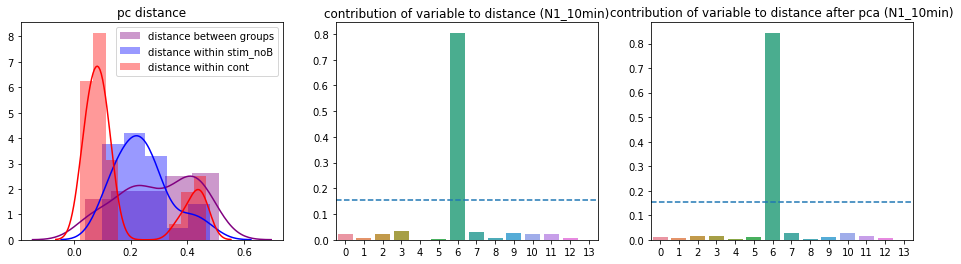

In [17]:
# plotting using my data ##################################

# extract PC distances array (first step in pc_dist)
#nparray = np.concatenate((csv_group1,csv_group2),axis=0)
#a,b,c = pca_on_np_array(nparray)

#display(a.shape)
#save_where = os.path.join(file_path,curr_dataset)
#np.savetxt(save_where+'/'+curr_dataset+'_'+which_day+'_'+sesh_len+'_PCSarray.txt', nparray_represented_as_pcs, delimiter=',', fmt="%.2f")

f, axes = plt.subplots(1,3)
f.set_size_inches(16,4)

exampleN_between,exampleN_within1,exampleN_within2=pc_dist(csv_group1,csv_group2)

sns.distplot(exampleN_between, color='purple',label=['distance between groups'],ax=axes[0])
sns.distplot(exampleN_within1, color='blue',label=['distance within '+group1_name],ax=axes[0])
sns.distplot(exampleN_within2, color='red',label=['distance within '+group2_name],ax=axes[0])
axes[0].set_title('pc distance')
axes[0].legend()


exampleN_raw=contribution_of_each_syllable_to_distance_raw(csv_group1,csv_group2)

sns.barplot(x=np.array(range(n_syllables)),y=exampleN_raw,ax=axes[1])
exampleN_raw_title = 'contribution of variable to distance ('+which_day+'_'+sesh_len+')'
axes[1].set_title(exampleN_raw_title)
axes[1].axhline(cutoff, ls='--')


exampleN_after=contribution_of_each_syllable_to_distance(csv_group1,csv_group2)

sns.barplot(x=np.array(range(n_syllables)),y=exampleN_after,ax=axes[2])
exampleN_after_title = 'contribution of variable to distance after pca ('+which_day+'_'+sesh_len+')'
axes[2].set_title(exampleN_after_title)
axes[2].axhline(cutoff, ls='--')

In [18]:
save_where = os.path.join(file_path,curr_dataset)
print(save_where)

np.savetxt(save_where+'/'+curr_dataset+'_between_'+which_day+'_'+sesh_len+'.txt', exampleN_between, delimiter=',', fmt="%.3f")
np.savetxt(save_where+'/'+curr_dataset+'_within1_'+which_day+'_'+sesh_len+'.txt', exampleN_within1, delimiter=',', fmt="%.3f")
np.savetxt(save_where+'/'+curr_dataset+'_within2_'+which_day+'_'+sesh_len+'.txt', exampleN_within2, delimiter=',', fmt="%.3f")
np.savetxt(save_where+'/'+curr_dataset+'_raw_'+which_day+'_'+sesh_len+'.txt', exampleN_raw, delimiter=',', fmt="%.8f")
np.savetxt(save_where+'/'+curr_dataset+'_afterPCA_'+which_day+'_'+sesh_len+'.txt', exampleN_after, delimiter=',', fmt="%.8f")
f.savefig(save_where+'/'+curr_dataset+'_PCA_sylGroupDist_'+which_day+'_'+sesh_len+'.png')

/Users/cakiti/Dropbox (Uchida Lab)/Korleki Akiti/Behavior/Standard setup/CombineAnalysis/Dataset_20190723


In [ ]:
# example models
# two groups, each have n_mice mice and produce n_syllables syllables
n_mice=9
n_syllables=20

save_where = '/Users/cakiti/Dropbox (Uchida Lab)/Korleki Akiti/Behavior/Standard setup/CombineAnalysis/example_models'
print(save_where)

#STatiStiCal SIGniFicAncE
#the cutoff should be interpreted as: while all syllables contribute to the distance between groups mathematically,
#only (cutoff-1)% of unintended (randomly walking) syllables should fall above the line.
#this is not the fdr! In all examples, we draw from a random uniform distribution, however, 
#biologial variables are often drawn from normal or exponential distributions
cutoff=.95
compounds=int(np.ceil(np.log2(1/(1-cutoff))))
comp=[]

for i in range(compounds):
    comp.append((1.0/n_syllables)/(2.0*(i+1.0)))
cutoff=(1.0/n_syllables) + sum(comp)

In [ ]:
#example1: group2 (red) uses each of it's syllables about twice as much (+.5)
which_example = 1
example_group1=np.random.rand(n_mice,n_syllables)
example_group2=np.random.rand(n_mice,n_syllables)+.5

In [ ]:
#example2: group2 (red) uses the first syllable ~ three times as much (~+1) as group 1 does
which_example = 2
example_group1=np.random.rand(n_mice,n_syllables)
example_group2=np.random.rand(n_mice,n_syllables)
example_group2[:,2]+=1.5

In [ ]:
#example 3: two groups' variables (syllables) are drawn from same distribution
which_example = 3
example_group1=np.random.rand(n_mice,n_syllables)
example_group2=np.random.rand(n_mice,n_syllables)

In [ ]:
#example 4: variables (syllables) 2 and 5 are expressed much higher in group 1 vs group 2
which_example = 4
example_group1=np.random.rand(n_mice,n_syllables)
example_group2=np.random.rand(n_mice,n_syllables)
example_group2[:,2]+=.5
example_group2[:,5]+=.5

In [ ]:
#example 5: variables (syllables) 5 and 9 are perfectly correlated,  and 5 and 1 are expressed more in group 2
which_example = 5
example_group1=np.random.rand(n_mice,n_syllables)
example_group2=np.random.rand(n_mice,n_syllables)
example_group1[:,9]=example_group1[:,5]*1.1 #variable 9 is 110% of variable 5
example_group2[:,9]=example_group2[:,5]*1.1 
example_group2[:,5]+=.5
example_group2[:,1]+=.5

In [ ]:
#example 6: one mouse in group 1 is weird (expresses some syllables more)
which_example = 6
example_group1=np.random.rand(n_mice,n_syllables)
example_group2=np.random.rand(n_mice,n_syllables)
example_group1[3,2]+=2
example_group1[3,6]+=.5
example_group1[3,7]+=2

In [ ]:
# plotting and saving example
display(which_example)
example_between,example_within1,example_within2=pc_dist(example_group1,example_group2)

f, axes = plt.subplots(1,3)
f.set_size_inches(16,4)

sns.distplot(example_between, color='purple',label=['distance between groups'],ax=axes[0])
sns.distplot(example_within1, color='blue',label=['distance within group 1'],ax=axes[0])
sns.distplot(example_within2, color='red',label=['distance within group 2'],ax=axes[0])
axes[0].set_title('pc distance')
axes[0].legend()

example=contribution_of_each_syllable_to_distance_raw(example_group1,example_group2)
sns.barplot(x=np.array(range(n_syllables)),y=example,ax=axes[1])
axes[1].set_title('contribution of variable to distance')
axes[1].axhline(cutoff, ls='--')

example=contribution_of_each_syllable_to_distance(example_group1,example_group2)
sns.barplot(x=np.array(range(n_syllables)),y=example,ax=axes[2])
axes[2].set_title('contribution of variable to distance after pca')
axes[2].axhline(cutoff, ls='--')

#np.savetxt(save_where+'/example'+str(which_example)+'_within1_.txt', example_within1, delimiter=',', fmt="%.3f")
#np.savetxt(save_where+'/example'+str(which_example)+'_within2_.txt', example_within2, delimiter=',', fmt="%.3f")
#np.savetxt(save_where+'/example'+str(which_example)+'_between_.txt', example_between, delimiter=',', fmt="%.3f")
#f.savefig(save_where+'/example'+str(which_example)+'_PCA_sylGroupDist.png')

In [ ]:
np.savetxt(save_where+'/example'+str(which_example)+'_within1_.txt', example_within1, delimiter=',', fmt="%.3f")
np.savetxt(save_where+'/example'+str(which_example)+'_within2_.txt', example_within2, delimiter=',', fmt="%.3f")
np.savetxt(save_where+'/example'+str(which_example)+'_between_.txt', example_between, delimiter=',', fmt="%.3f")
f.savefig(save_where+'/example'+str(which_example)+'_PCA_sylGroupDist.png')